# Initialize the model
Here we import the required packages and use a default model that contains a nitrogen-vacancy (NV) electron spin and a $^{13}\text{C}$ nuclear spin. Qubit subspace is defined as $m_S=$($0$,$-1$) states of the NV electron and $m_I=$($-1/2$,$1/2$) states of the nuclear spin.


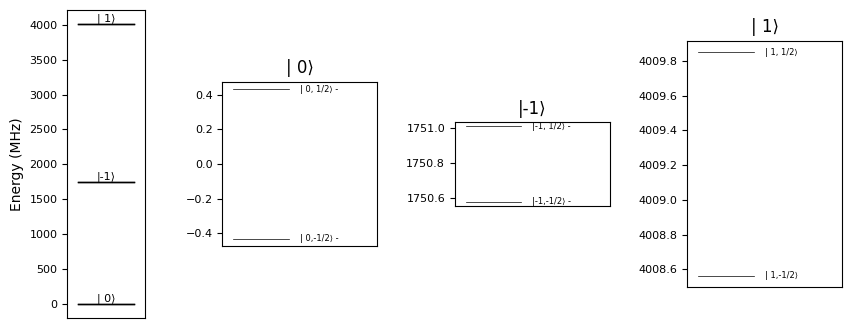

In [1]:
import numpy as np
np.set_printoptions(suppress=True, linewidth=10000, precision=3)
import matplotlib.pyplot as plt

import simphony
simphony.Config.set_platform('gpu')

model = simphony.default_model('13C', interaction=True)

model.calculate_hamiltonians()
model.plot_levels()

# Conventional NMR pulse
First we simulate a NMR RX($\pi$) pulse controlled on the NV electron $m_S=-1$ state, that is closely related to a $\text{CNOT}$ gate.

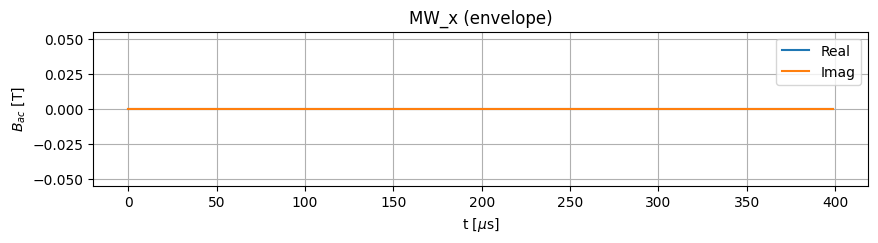

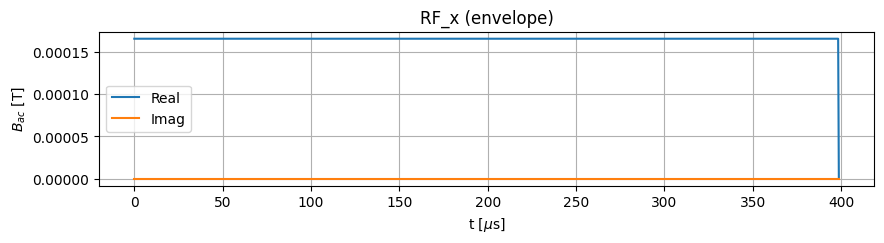

In [2]:
model = simphony.default_gate(model, '13C controlled pi pulse')
model.plot_pulse(function='envelope')

## Noiseless simulation

In [3]:
result_noiseless = model.simulate_time_evolution(verbose=True)

method : jax_expm_parallel
simulate : segment [0, 398.792] with step size 0.02289


Plot the Bloch vectors (top - electron spin, bottom - nuclear spin) starting from the initial state described by $m_S=-1$ and $m_I=-1/2$.

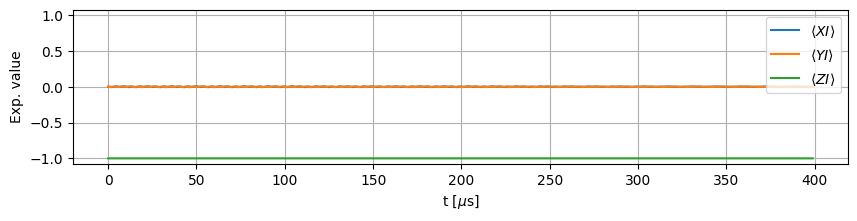

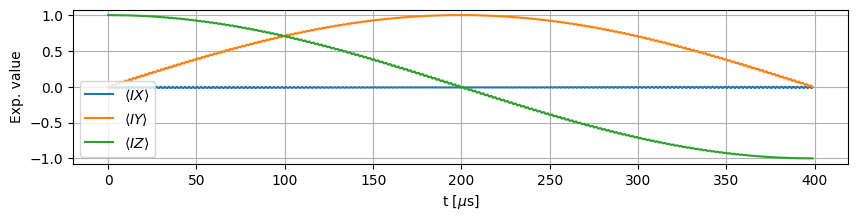

In [4]:
state = model.state({'NV-e': -1, '13C': -1/2}, basis='product')
result_noiseless.initial_state = state

result_noiseless.operators = ['XI','YI','ZI']
result_noiseless.plot_expectation_values(shot=0, basis='product', frame='rotating')

result_noiseless.operators = ['IX','IY','IZ']
result_noiseless.plot_expectation_values(shot=0, basis='product', frame='rotating')

Plot the process matrix in the qubit subspace:

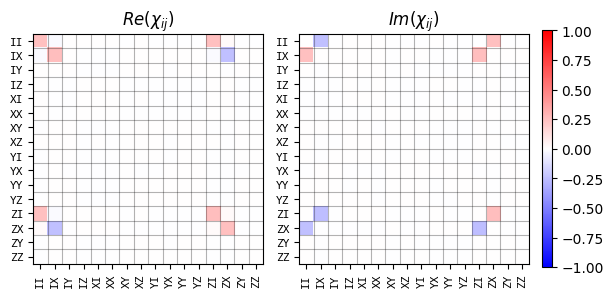

In [5]:
result_noiseless.plot_process_matrix(value='real-imag', basis='product', frame='rotating')

Plot the process matrix of the ideal gate and calculate the average gate fidelity:

Average gate fidelity = 0.9986859730600091


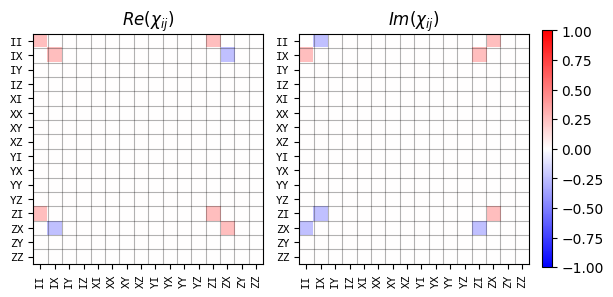

In [6]:
ideal_gate = simphony.GateControlled(target='13C',
                                     axis='x',
                                     angle=np.pi,
                                     control='NV-e',
                                     control_state='1')

result_noiseless.ideal_gate = ideal_gate
result_noiseless.ideal_gate.plot_process_matrix(value='real-imag')

average_gate_fidelity = result_noiseless.average_gate_fidelity()
print('Average gate fidelity = {}'.format(average_gate_fidelity))

## Noisy simulation
Here we include a local quasistatic noise on the NV electron spin with a strength of $1\text{ MHz}$ and on the nuclear spin with $0.00001\text{ MHz}$, then simulate $256$ shots.

In [7]:
model.spin('NV-e').local_quasistatic_noise.z = 1 # MHz
model.spin('13C').local_quasistatic_noise.z = 0.00001 # MHz

result_noisy = model.simulate_time_evolution(n_shots=256, random_seed=42)

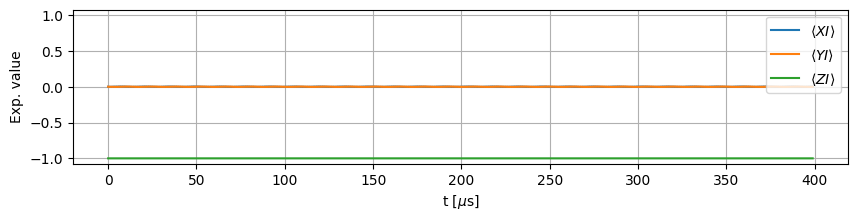

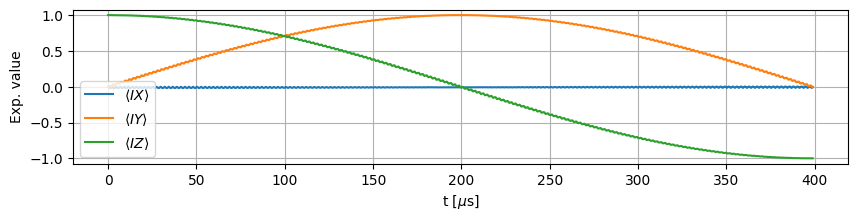

In [8]:
state = model.state({'NV-e': -1, '13C': -1/2}, basis='product')
result_noisy.initial_state = state

result_noisy.operators = ['XI','YI','ZI']
result_noisy.plot_expectation_values(shot='avg', basis='product', frame='rotating')

result_noisy.operators = ['IX','IY','IZ']
result_noisy.plot_expectation_values(shot='avg', basis='product', frame='rotating')

Plot the shot-averaged process matrix in the qubit subspace. Note that the imaginary part is vanished.

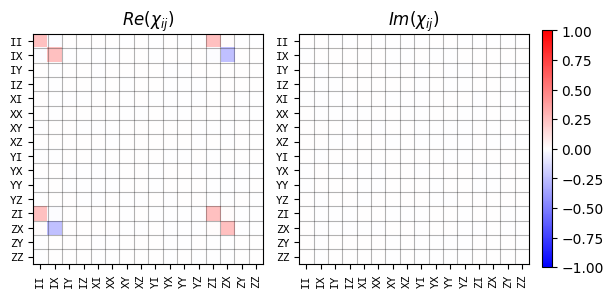

In [9]:
result_noisy.plot_process_matrix(value='real-imag', shot='avg', basis='product', frame='rotating')

The average gate fidelity significantly decreases.

In [10]:
result_noisy.ideal_gate = ideal_gate
average_gate_fidelity = result_noisy.average_gate_fidelity(basis='product')
print('Average gate fidelity = {}'.format(average_gate_fidelity))

Average gate fidelity = 0.6668072942532299


# DDRF gates
Here we simulate the same gate realized by two DDRF gates, a conditional (controlled) and an unconditional one. Scheme of a DDRF gate is based on a phase-controlled radio-frequency driving of the nuclear spin interleaved with dynamical decoupling of the electron spin.

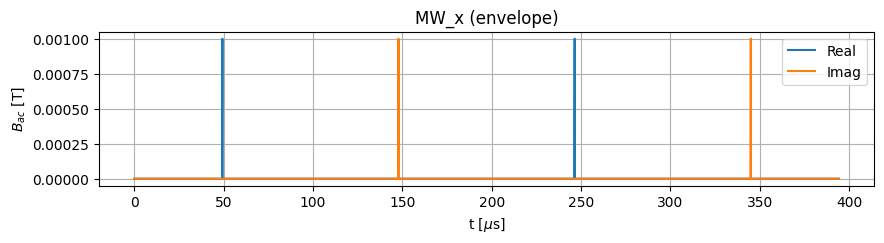

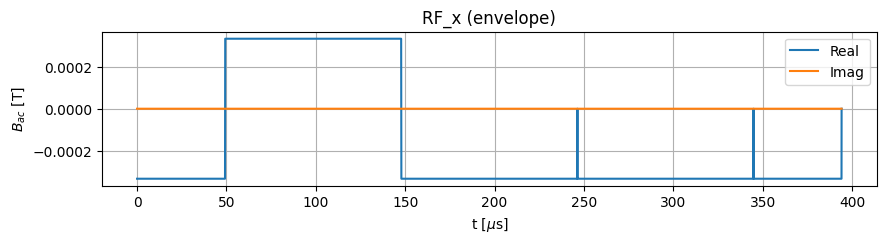

In [11]:
model.reset_driving_fields()
model = simphony.default_gate(model, '13C CNOT DDRF')
model.plot_pulse(function='envelope')

Simulate $256$ shots for this pulse sequences.

In [12]:
result_noisy_ddrf = model.simulate_time_evolution(n_shots=256, random_seed=42)

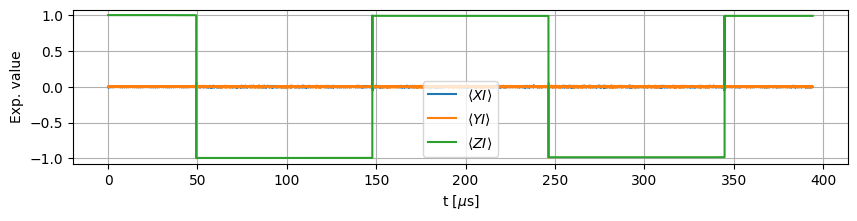

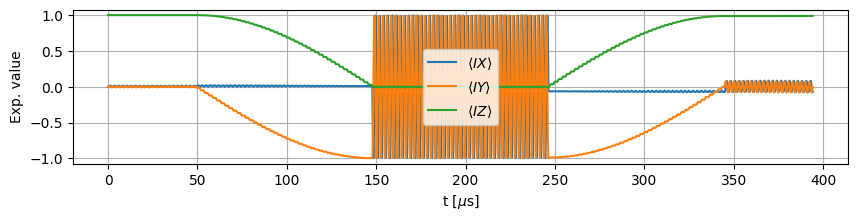

In [13]:
state = model.state({'NV-e': 0, '13C': -1/2}, basis='product')
result_noisy_ddrf.initial_state = state

result_noisy_ddrf.operators = ['XI','YI','ZI']
result_noisy_ddrf.plot_expectation_values(shot='avg', basis='product', frame='rotating')

result_noisy_ddrf.operators = ['IX','IY','IZ']
result_noisy_ddrf.plot_expectation_values(shot='avg', basis='product', frame='rotating')

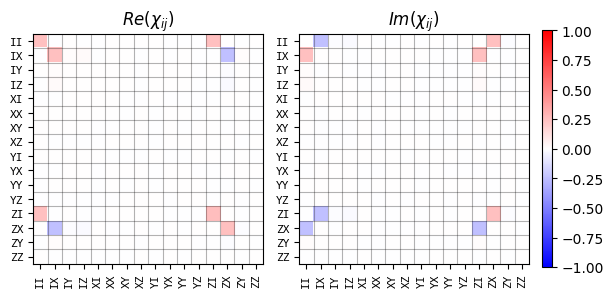

In [14]:
result_noisy_ddrf.plot_process_matrix(value='real-imag', shot='avg', basis='product', frame='rotating')

The process matrix reflects the effects of the noise, but the average gate fidelity is significantly improved by the dynamical decoupling.

In [15]:
result_noisy_ddrf.ideal_gate = ideal_gate
average_gate_fidelity = result_noisy_ddrf.average_gate_fidelity()
print('Average gate fidelity = {}'.format(average_gate_fidelity))

Average gate fidelity = 0.9929613647748702
